In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.datasets import GraphDataset

%reload_ext autoreload
%autoreload 2

In [2]:
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.outliers.benchmark_utils.embed import build_features
from NEExT.outliers.benchmark_utils.embed import build_embeddings
from NEExT.outliers.benchmark_utils.supervised import supervised_eval

graph_io = GraphIO()
hide_frac = {0: 0.0, 1: 0.0}
k_hop = 1

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [3]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
egonet_collection = EgonetCollection(egonet_feature_target='is_outlier', skip_features=graph_data['skip_features'])
egonet_collection.compute_k_hop_egonets(graph_collection, k_hop)
structural_features, features = build_features(egonet_collection, feature_vector_length=k_hop, feature_list=graph_data["feature_list"])

In [4]:
positional_features = egonet_collection.compute_egonet_positionaL_features()
structural_features +=positional_features 

In [5]:
structural_features.features_df

,node_id,graph_id,page_rank_0,degree_centrality_0,closeness_centrality_0,betweenness_centrality_0,eigenvector_centrality_0,clustering_coefficient_0,local_efficiency_0,lsme_0,load_centrality_0,basic_expansion_0,egonet_position_0,egonet_position_1
0,0,0,0.122240,1.000000,1.000000,694.007540,1.000000,0.124082,0.475643,50.0,694.007540,6.311881,1,0
1,0,1,0.056810,0.500000,0.666667,77.524206,0.697044,0.266667,0.576923,25.0,77.524206,3.236041,0,1
2,0,2,0.135581,1.000000,1.000000,758.148413,1.000000,0.109694,0.452199,49.0,758.148413,6.882022,1,0
3,0,3,0.117555,1.000000,1.000000,630.252381,1.000000,0.129433,0.467058,48.0,630.252381,6.061856,1,0
4,0,4,0.159663,1.000000,1.000000,790.067857,1.000000,0.091582,0.398252,47.0,790.067857,7.726027,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,49,0,0.005019,0.020000,0.505051,0.000000,0.074923,0.000000,0.000000,1.0,0.000000,0.126238,0,1
10744,49,1,0.011272,0.080000,0.520833,0.625000,0.175206,0.666667,0.750000,4.0,0.625000,0.517766,0,1
10745,49,2,0.010042,0.061224,0.515789,0.250000,0.133739,0.666667,0.750000,3.0,0.250000,0.421348,0,1
10746,50,0,0.008862,0.060000,0.515464,0.000000,0.162791,1.000000,1.000000,3.0,0.000000,0.378713,0,1


In [6]:
embeddings = build_embeddings(
    egonet_collection,
    structural_features,
    features,
    strategy="structural_embeddings",
    embeddings_dimension=5,
    embeddings_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = GraphDataset(egonet_collection, embeddings, standardize=False)

In [7]:
model = "lgbm"
out_df, score = supervised_eval(model, ground_truth_df, dataset)
score

[I 2025-04-30 21:45:42,752] A new study created in memory with name: no-name-9a91321e-b70c-4e34-b10c-dcb604769a5f


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[4]	valid_0's auc: 0.810391
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown 

[I 2025-04-30 21:45:48,182] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 62, 'min_data_in_leaf': 2, 'num_leaves': 26, 'max_depth': 100, 'class_weight': 'balanced', 'learning_rate': 0.1143048567239196, 'colsample_bytree': 0.222580708349612}. Best is trial 0 with value: 0.5.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.865313
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

[I 2025-04-30 21:45:48,265] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 54, 'min_data_in_leaf': 5, 'num_leaves': 54, 'max_depth': 55, 'class_weight': None, 'learning_rate': 0.002598241454852606, 'colsample_bytree': 0.7858842305559228}. Best is trial 0 with value: 0.5.
[I 2025-04-30 21:45:48,280] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 55, 'min_data_in_leaf': 9, 'num_leaves': 37, 'max_depth': 93, 'class_weight': 'balanced', 'learning_rate': 0.14499059128201597, 'colsample_bytree': 0.6218327967454578}. Best is trial 0 with value: 0.5.
[I 2025-04-30 21:45:48,342] Trial 5 finished with value: 0.5 and parameters: {'n_estimators': 56, 'min_data_in_leaf': 7, 'num_leaves': 24, 'max_depth': 63, 'class_weight': 'balanced', 'learning_rate': 0.047521417946506696, 'colsample_bytree': 0.8283298404677206}. Best is trial 0 with value: 0.5.
[I 2025-04-30 21:45:48,356] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 3, 'min_data_in_leaf':

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	valid_0's auc: 0.854844
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negati

[I 2025-04-30 21:45:48,475] Trial 7 finished with value: 0.5 and parameters: {'n_estimators': 31, 'min_data_in_leaf': 5, 'num_leaves': 88, 'max_depth': 15, 'class_weight': None, 'learning_rate': 0.00023708556691132916, 'colsample_bytree': 0.3184746439406892}. Best is trial 0 with value: 0.5.
[I 2025-04-30 21:45:48,520] Trial 9 finished with value: 0.5 and parameters: {'n_estimators': 33, 'min_data_in_leaf': 6, 'num_leaves': 89, 'max_depth': 15, 'class_weight': 'balanced', 'learning_rate': 0.0038100102057726337, 'colsample_bytree': 0.9336538488474562}. Best is trial 0 with value: 0.5.
[I 2025-04-30 21:45:48,538] Trial 8 finished with value: 0.525 and parameters: {'n_estimators': 57, 'min_data_in_leaf': 10, 'num_leaves': 97, 'max_depth': 77, 'class_weight': 'balanced', 'learning_rate': 0.29820981414543846, 'colsample_bytree': 0.4224392675657129}. Best is trial 8 with value: 0.525.
[I 2025-04-30 21:45:48,565] Trial 10 finished with value: 0.6275000000000001 and parameters: {'n_estimators'

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

[I 2025-04-30 21:45:48,807] Trial 13 finished with value: 0.6468750000000001 and parameters: {'n_estimators': 73, 'min_data_in_leaf': 10, 'num_leaves': 99, 'max_depth': 73, 'class_weight': None, 'learning_rate': 4.405900553986317, 'colsample_bytree': 0.4373485445147328}. Best is trial 13 with value: 0.6468750000000001.
[I 2025-04-30 21:45:48,848] Trial 14 finished with value: 0.65 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 10, 'num_leaves': 98, 'max_depth': 74, 'class_weight': None, 'learning_rate': 6.630588897336258, 'colsample_bytree': 0.4127847372140784}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:48,864] Trial 15 finished with value: 0.65 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 10, 'num_leaves': 99, 'max_depth': 76, 'class_weight': None, 'learning_rate': 8.755871145258748, 'colsample_bytree': 0.45526251938549583}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:48,902] Trial 16 finished with value: 0.65 and parameters: {'n_estimator

[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2025-04-30 21:45:49,081] Trial 17 finished with value: 0.65 and parameters: {'n_estimators': 74, 'min_data_in_leaf': 3, 'num_leaves': 76, 'max_depth': 38, 'class_weight': None, 'learning_rate': 8.660367259156121, 'colsample_bytree': 0.4709870764559582}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,108] Trial 18 finished with value: 0.65 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 10, 'num_leaves': 75, 'max_depth': 39, 'class_weight': None, 'learning_rate': 4.1805526529272425, 'colsample_bytree': 0.4519028576831392}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,127] Trial 20 finished with value: 0.608125 and parameters: {'n_estimators': 16, 'min_data_in_leaf': 9, 'num_leaves': 72, 'max_depth': 39, 'class_weight': None, 'learning_rate': 1.00699194196534, 'colsample_bytree': 0.5417050665615041}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,140] Trial 19 finished with value: 0.5856250000000001 and parameters: {'n_estimators': 71, 'min_

[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No furt

[I 2025-04-30 21:45:49,341] Trial 21 finished with value: 0.573125 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 9, 'num_leaves': 72, 'max_depth': 42, 'class_weight': None, 'learning_rate': 1.050028480205878, 'colsample_bytree': 0.5371668372102238}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,384] Trial 22 finished with value: 0.58875 and parameters: {'n_estimators': 19, 'min_data_in_leaf': 8, 'num_leaves': 74, 'max_depth': 83, 'class_weight': None, 'learning_rate': 0.7826742100151997, 'colsample_bytree': 0.5273760450300287}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,399] Trial 23 finished with value: 0.575 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 1, 'num_leaves': 98, 'max_depth': 78, 'class_weight': None, 'learning_rate': 1.0848018426855062, 'colsample_bytree': 0.37300714547624186}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,418] Trial 24 finished with value: 0.5743750000000001 and parameters: {'n_estimators': 66,

[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data p

[I 2025-04-30 21:45:49,575] Trial 25 finished with value: 0.561875 and parameters: {'n_estimators': 66, 'min_data_in_leaf': 1, 'num_leaves': 100, 'max_depth': 80, 'class_weight': None, 'learning_rate': 1.8771325936210588, 'colsample_bytree': 0.3546815121582034}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,697] Trial 26 finished with value: 0.63875 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 1, 'num_leaves': 99, 'max_depth': 67, 'class_weight': None, 'learning_rate': 2.472978008701713, 'colsample_bytree': 0.36760823018305594}. Best is trial 14 with value: 0.65.


[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2025-04-30 21:45:49,743] Trial 27 finished with value: 0.65 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 4, 'num_leaves': 84, 'max_depth': 67, 'class_weight': None, 'learning_rate': 2.8394446339541908, 'colsample_bytree': 0.32128620397484475}. Best is trial 14 with value: 0.65.
[I 2025-04-30 21:45:49,745] Trial 28 finished with value: 0.74875 and parameters: {'n_estimators': 68, 'min_data_in_leaf': 4, 'num_leaves': 83, 'max_depth': 66, 'class_weight': None, 'learning_rate': 3.0790083778440684, 'colsample_bytree': 0.29745452533314554}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:49,880] Trial 29 finished with value: 0.5 and parameters: {'n_estimators': 69, 'min_data_in_leaf': 4, 'num_leaves': 83, 'max_depth': 66, 'class_weight': None, 'learning_rate': 0.32322885923808714, 'colsample_bytree': 0.2768532236203501}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,012] Trial 30 finished with value: 0.515625 and parameters: {'n_estimators': 70, 'min_d

[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2025-04-30 21:45:50,054] Trial 31 finished with value: 0.5 and parameters: {'n_estimators': 60, 'min_data_in_leaf': 8, 'num_leaves': 91, 'max_depth': 48, 'class_weight': None, 'learning_rate': 0.3543708263472352, 'colsample_bytree': 0.21076570426073313}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,115] Trial 32 finished with value: 0.51375 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 8, 'num_leaves': 91, 'max_depth': 89, 'class_weight': None, 'learning_rate': 0.28365848635877255, 'colsample_bytree': 0.21323542715613686}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,197] Trial 33 finished with value: 0.5131249999999999 and parameters: {'n_estimators': 42, 'min_data_in_leaf': 8, 'num_leaves': 92, 'max_depth': 88, 'class_weight': None, 'learning_rate': 0.34586375872959324, 'colsample_bytree': 0.2090755916107587}. Best is trial 28 with value: 0.74875.


[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2025-04-30 21:45:50,354] Trial 34 finished with value: 0.65 and parameters: {'n_estimators': 60, 'min_data_in_leaf': 3, 'num_leaves': 91, 'max_depth': 85, 'class_weight': None, 'learning_rate': 9.010419452396807, 'colsample_bytree': 0.4212111086712124}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,375] Trial 35 finished with value: 0.65 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 3, 'num_leaves': 94, 'max_depth': 85, 'class_weight': None, 'learning_rate': 8.003850835176008, 'colsample_bytree': 0.3916957125238977}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,449] Trial 36 finished with value: 0.666875 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 3, 'num_leaves': 93, 'max_depth': 86, 'class_weight': None, 'learning_rate': 8.57980464561288, 'colsample_bytree': 0.6104651295849062}. Best is trial 28 with value: 0.74875.


[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Earl

[I 2025-04-30 21:45:50,541] Trial 37 finished with value: 0.666875 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 3, 'num_leaves': 81, 'max_depth': 72, 'class_weight': None, 'learning_rate': 8.918740723683184, 'colsample_bytree': 0.5804563806502006}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,692] Trial 39 finished with value: 0.5 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 2, 'num_leaves': 80, 'max_depth': 72, 'class_weight': None, 'learning_rate': 0.00043263417614970836, 'colsample_bytree': 0.5962736428897123}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,724] Trial 38 finished with value: 0.6625 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 6, 'num_leaves': 45, 'max_depth': 71, 'class_weight': None, 'learning_rate': 4.682688793584513, 'colsample_bytree': 0.607841253757418}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:50,797] Trial 40 finished with value: 0.5606249999999999 and parameters: {'n_estimator

[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2025-04-30 21:45:50,865] Trial 41 finished with value: 0.5 and parameters: {'n_estimators': 48, 'min_data_in_leaf': 2, 'num_leaves': 64, 'max_depth': 60, 'class_weight': None, 'learning_rate': 0.0003349742141774583, 'colsample_bytree': 0.6153174706940832}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,036] Trial 42 finished with value: 0.6587500000000001 and parameters: {'n_estimators': 69, 'min_data_in_leaf': 5, 'num_leaves': 67, 'max_depth': 94, 'class_weight': 'balanced', 'learning_rate': 2.5115968965845177, 'colsample_bytree': 0.6042834221401073}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,070] Trial 43 finished with value: 0.5 and parameters: {'n_estimators': 69, 'min_data_in_leaf': 6, 'num_leaves': 41, 'max_depth': 60, 'class_weight': 'balanced', 'learning_rate': 0.13769991897593856, 'colsample_bytree': 0.7288373369779968}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,156] Trial 44 finished with value: 0.6587500000000001 and par

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-04-30 21:45:51,349] Trial 46 finished with value: 0.5 and parameters: {'n_estimators': 68, 'min_data_in_leaf': 6, 'num_leaves': 45, 'max_depth': 96, 'class_weight': 'balanced', 'learning_rate': 1.4740806512508275e-05, 'colsample_bytree': 0.7049054666823906}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,386] Trial 47 finished with value: 0.6587500000000001 and parameters: {'n_estimators': 63, 'min_data_in_leaf': 5, 'num_leaves': 45, 'max_depth': 94, 'class_weight': 'balanced', 'learning_rate': 2.925336381822127, 'colsample_bytree': 0.6670915203893901}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,426] Trial 48 finished with value: 0.645 and parameters: {'n_estimators': 62, 'min_data_in_leaf': 5, 'num_leaves': 48, 'max_depth': 93, 'class_weight': 'balanced', 'learning_rate': 1.7076119803506131, 'colsample_bytree': 0.6597808074569065}. Best is trial 28 with value: 0.74875.
[I 2025-04-30 21:45:51,428] Trial 49 finished with value: 0.60875 and paramet

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 120, number of negative: 480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

0.7906249999999999

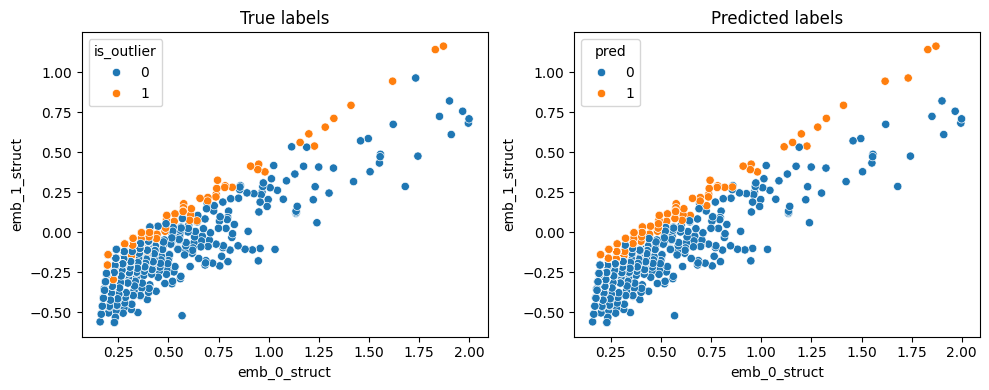

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


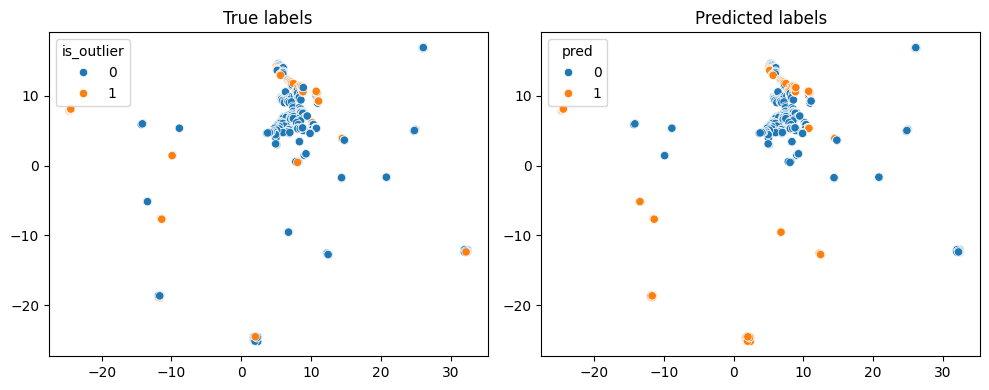

In [9]:
import umap

reduced = umap.UMAP().fit_transform(embeddings.embeddings_df.iloc[:, 1:])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()